# Denoise Autoencoder

In [1]:
# import libs
import numpy as np
from keras.datasets import mnist

In [2]:
(X_train , _) ,(X_test, _) = mnist.load_data()
X_train.shape

(60000, 28, 28)

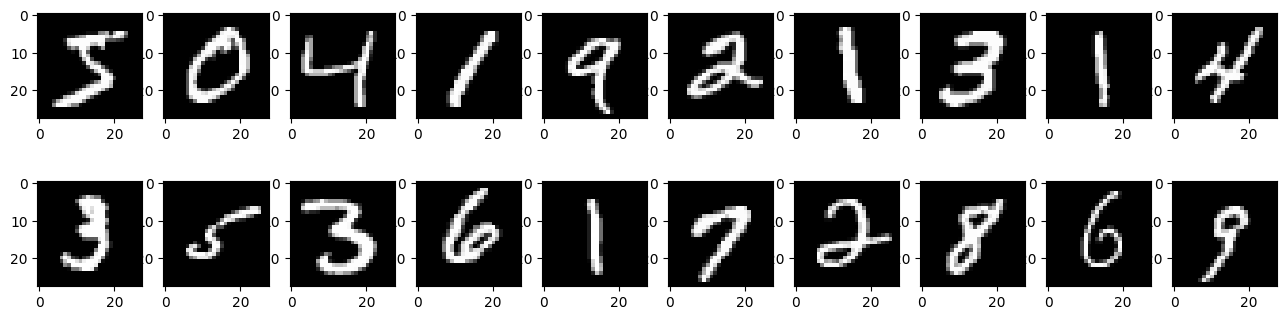

In [3]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(2,10, figsize = (16, 4))

count = 0

for i in range(2):
    for j in range(10):
        axes[i,j].imshow(X_train[count], cmap = 'gray')
        count+=1

## Normalize

In [4]:
X_train = X_train / 255.0
X_test = X_test / 255.0

## Add noise to images

In [5]:
# prepare source data
noise_factor = 0.1

X_train_noise = X_train + noise_factor * np.random.normal(loc = 0., scale = 1., size = X_train.shape)
X_test_noise = X_test + noise_factor * np.random.normal(loc = 0., scale = 1., size = X_test.shape)

In [6]:
X_train.shape

(60000, 28, 28)

## Visualize noisy data

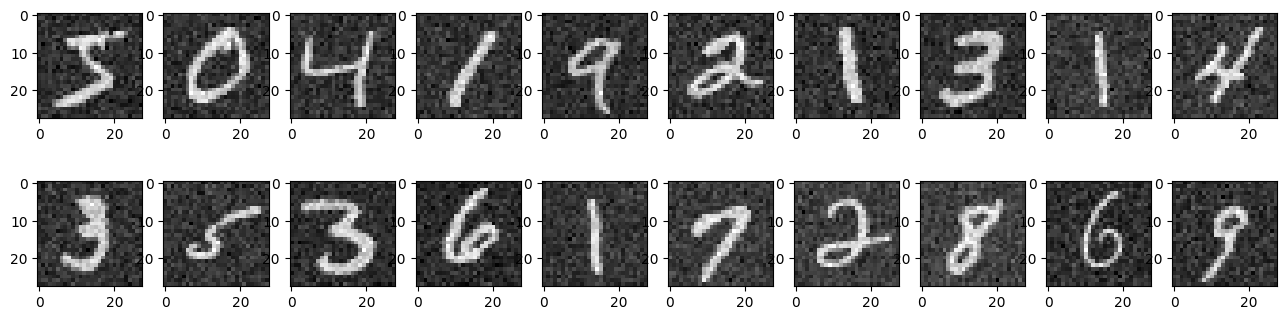

In [7]:
fig, axes = plt.subplots(2,10, figsize = (16,4))

count = 0
for i in range(2):
    for j in range(10):
        axes[i,j].imshow(X_train_noise[count], cmap = 'gray')
        count+=1

# Reshape dataset

In [8]:
X_train = X_train.reshape(X_train.shape[0], 28 ,28, 1)
X_test = X_test.reshape(X_test.shape[0], 28,28,1)

X_train_noise = X_train_noise.reshape(X_train_noise.shape[0], 28 ,28, 1)
X_test_noise = X_test_noise.reshape(X_test_noise.shape[0], 28,28,1)

X_train.shape, X_train_noise.shape

((60000, 28, 28, 1), (60000, 28, 28, 1))

## Model

In [9]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Dense, UpSampling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint

import tensorflow as tf

In [12]:
devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(devices[0], enable = True)

In [ ]:
# encoder
encoder_input = Input(shape = X_train.shape[1:])
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(encoder_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size = (2,2), padding = 'same')(x)
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
encoded = MaxPool2D(pool_size = (2,2), padding = 'same')(x)

In [ ]:
# decoder
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(encoded)
x = BatchNormalization()(x)
x = UpSampling2D()(x)
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = UpSampling2D()(x)
decoded = Conv2D(1, (3,3), activation = 'sigmoid', padding = 'same')(x)

In [ ]:
autoencoder = Model(encoder_input, decoded, name = 'Denoising_Model')
autoencoder.summary()

Model: "Denoising_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)      

In [ ]:
autoencoder.compile(loss = 'binary_crossentropy', optimizer = 'adam')

# Train the model

In [ ]:
checkpoint = ModelCheckpoint("denoising_model.h5", save_best_only=True, save_weights_only=False, verbose = 1)
history = autoencoder.fit(X_train_noise, X_train, batch_size = 128, epochs = 50, callbacks = checkpoint, validation_split = 0.25, verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.13133, saving model to denoising_model.h5
352/352 - 4s - loss: 0.1585 - val_loss: 0.1313
Epoch 2/50

Epoch 00002: val_loss improved from 0.13133 to 0.07565, saving model to denoising_model.h5
352/352 - 4s - loss: 0.0762 - val_loss: 0.0756
Epoch 3/50

Epoch 00003: val_loss did not improve from 0.07565
352/352 - 3s - loss: 0.0733 - val_loss: 0.0764
Epoch 4/50

Epoch 00004: val_loss improved from 0.07565 to 0.07197, saving model to denoising_model.h5
352/352 - 4s - loss: 0.0718 - val_loss: 0.0720
Epoch 5/50

Epoch 00005: val_loss did not improve from 0.07197
352/352 - 3s - loss: 0.0710 - val_loss: 0.0728
Epoch 6/50

Epoch 00006: val_loss improved from 0.07197 to 0.07053, saving model to denoising_model.h5
352/352 - 4s - loss: 0.0704 - val_loss: 0.0705
Epoch 7/50

Epoch 00007: val_loss improved from 0.07053 to 0.07004, saving model to denoising_model.h5
352/352 - 4s - loss: 0.0700 - val_loss: 0.0700
Epoch 8/50

Epoch 00008: val_loss 

In [ ]:
# load best performance model
from keras.models import load_model
autoencoder = load_model('denoising_model.h5')
autoencoder.summary()

Model: "Denoising_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)      

In [ ]:
def visualize_data(data, row, column):
    data = data.reshape(data.shape[0], 28,28)
    count = 0
    fig, axes = plt.subplots(row, column, figsize = (16,4))
    for i in range(row):
        for j in range(column):
            axes[i,j].imshow(data[count], cmap = 'gray')
            count+=1

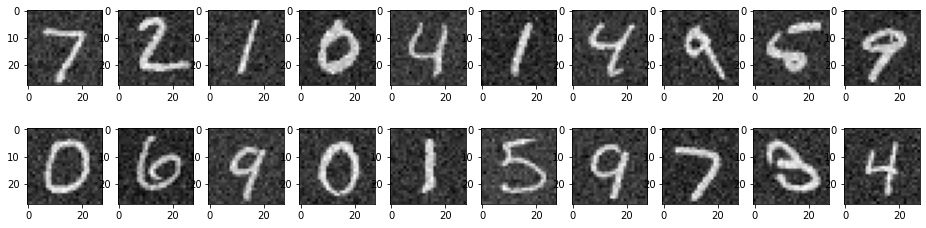

In [ ]:
visualize_data(X_test_noise[:20], 2,10)

In [ ]:
pred = autoencoder.predict(X_test_noise[:20])
pred.shape

(20, 28, 28, 1)

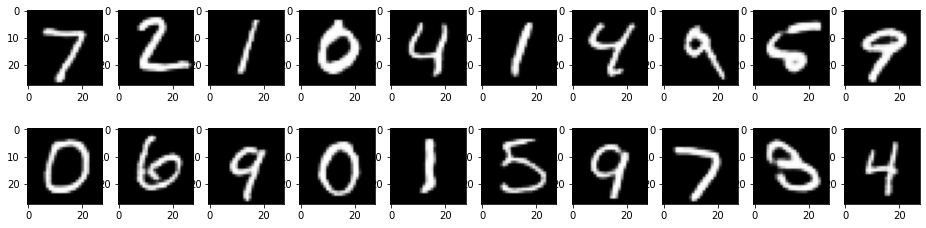

In [ ]:
visualize_data(pred, 2, 10)